## Human Pose Estimation using CycleGAN

The aim of this notebook is to map images of a human to his skeleton (described by the position of 17 main joints of his body) and vice versa.  

We will here solve this problem by training a CycleGAN on unpaired data. The data used consists of two distributions :
- images of the same person taking different poses (hm36 dataset) 
- pre-computed<sup>1</sup> skeleton, 

<sup>1</sup> *The skeletons are obtained by using another model on the hm36 dataset and then shuffled to simulate an unsupervised medium.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import sys
if "/cvlabdata1/home/gchraibi/pose_estimation/data" not in sys.path:
    sys.path.insert(1, "/cvlabdata1/home/gchraibi/pose_estimation/data")
    
from data.UnpairedHumanPoseDataset import UnpairedHumanPoseDataset
from data.helpers import visualize

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"         # To change according to GPU filling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
# Settings parameters
TRAIN = {'train_network': True,
         'save_network_and_losses': False,
         'load_network_and_losses': False, 
         'file_index': None }
TRAIN_AND_SAVE = {'train_network': True,
                  'save_network_and_losses': True,
                  'load_network_and_losses': False, 
                  'file_index': '1' }
LOAD = {'train_network': False,
        'save_network_and_losses': False,
        'load_network_and_losses': True, 
        'file_index': '1' }

CURRENT_SETTINGS = TRAIN

### Dataloader

In [4]:
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 4}

# Instantiation of the train and test dataset/dataloader

ds_train = UnpairedHumanPoseDataset(is_test = False, root_path = './data/human_cycle/')
dl_train = data.DataLoader(ds_train, **params)

ds_test = UnpairedHumanPoseDataset(is_test = True, root_path = './data/human_cycle/')
dl_test = data.DataLoader(ds_test, **params)

Loaded 11924 training samples from ./data/human_cycle/
Loaded 2636 testing samples from ./data/human_cycle/


### Networks

#### Generators

In [5]:
# Definition of the image to points generator
class I2PGenerator(nn.Module):
    
    def __init__(self):
        super(I2PGenerator, self).__init__()
        # We take a kernel of size 3, because we are dealing with small images (wrist might be often of 1px)
        self._conv2d1 = nn.Conv2d(3,16,3,stride=1,padding=0)
        self._conv2d2 = nn.Conv2d(16,16,3,stride=1,padding=1)
        self._conv2d3 = nn.Conv2d(16,32,3,stride=1,padding=0)
        self._maxpool2d1 = nn.MaxPool2d(kernel_size=2)
        self._conv2d4 = nn.Conv2d(32,32,3,stride=1,padding=0)
        self._conv2d5 = nn.Conv2d(32,64,3,stride=1,padding=0)
        self._maxpool2d2 = nn.MaxPool2d(kernel_size=2)
        self._conv2d6 = nn.Conv2d(64,64,3,stride=1,padding=0)
        self._conv2d7 = nn.Conv2d(64,128,3,stride=1,padding=1)
        self._maxpool2d3 = nn.MaxPool2d(kernel_size=2)
        self._conv2d8 = nn.Conv2d(128,256,3,stride=1,padding=0)
        self._conv2d9 = nn.Conv2d(256,256,3,stride=1,padding=0)
        self._conv2d10 = nn.Conv2d(256,512,3,stride=1,padding=1)
        self._conv2d11 = nn.Conv2d(512,512,3,stride=1,padding=0)
        self._conv2d12 = nn.Conv2d(512,1024,3,stride=1,padding=0)

        # We convert from 1024x2x2 to 1024x1x1, to have each of the 1024 "features" summarised in one element
        self._avg_pool = torch.nn.AvgPool2d(2)
        self._fc1 = nn.Linear(1024, 512)        
        self._fc2 = nn.Linear(512, 256)
        self._fc3 = nn.Linear(256, 128)
        self._fc4 = nn.Linear(128, 34)

        
    def forward(self, x):
        # No max_pool applied on the first layer to preserve the features
        x = F.relu(self._conv2d1(x))
        x = F.relu(self._conv2d2(x))
        x = F.relu(self._conv2d3(x))
        x = self._maxpool2d1(x)
        x = F.relu(self._conv2d4(x))
        x = F.relu(self._conv2d5(x))
        x = self._maxpool2d2(x)        
        x = F.relu(self._conv2d6(x))
        x = F.relu(self._conv2d7(x))
        x = self._maxpool2d3(x)
        x = F.relu(self._conv2d8(x))
        x = F.relu(self._conv2d9(x))
        x = F.relu(self._conv2d10(x))
        x = F.relu(self._conv2d11(x))
        x = F.relu(self._conv2d12(x))

        x = self._avg_pool(x)
        x = x.reshape((x.shape[0], -1))
        x = F.relu(self._fc1(x))
        x = F.relu(self._fc2(x))
        x = F.relu(self._fc3(x))
        x = self._fc4(x)

        return x.reshape((x.shape[0], 17, 2))

In [6]:
# Definition of the points to image generator (I2P inverse)
class P2IGenerator(nn.Module):
    
    def __init__(self):
        super(P2IGenerator, self).__init__()
        self._fc1 = nn.Linear(34, 128)
        self._fc2 = nn.Linear(128, 256)
        self._fc3 = nn.Linear(256, 512)
        self._fc4 = nn.Linear(512, 1024)
        
        self._unconv2d1 = nn.Conv2d(1024,512,3,stride=1,padding=1)
        self._unconv2d2 = nn.Conv2d(512,512,3,stride=1,padding=1)
        self._unconv2d3 = nn.Conv2d(512,256,3,stride=1,padding=2)
        self._unconv2d4 = nn.Conv2d(256,256,3,stride=1,padding=2)
        self._unconv2d5 = nn.Conv2d(256,128,3,stride=1,padding=2)
        self._unmaxpool2d1 = nn.ConvTranspose2d(128,128,2,stride=2)
        self._unconv2d6 = nn.Conv2d(128,64,3,stride=1,padding=1)
        self._unconv2d7 = nn.Conv2d(64,64,3,stride=1,padding=2)
        self._unmaxpool2d2 = nn.ConvTranspose2d(64,64,2,stride=2)        
        self._unconv2d8 = nn.Conv2d(64,32,3,stride=1,padding=2)
        self._unconv2d9 = nn.Conv2d(32,32,3,stride=1,padding=2)
        self._unmaxpool2d3 = nn.ConvTranspose2d(32,32,2,stride=2)
        self._unconv2d10 = nn.Conv2d(32,16,3,stride=1,padding=2)
        self._unconv2d11 = nn.Conv2d(16,16,3,stride=1,padding=1)
        self._unconv2d12 = nn.Conv2d(16,3,3,stride=1,padding=2)
        
    # Generate a scalar which represents the value in the other distribution
    def forward(self, x):
        x = x.reshape((x.shape[0], 34))
        x = F.relu(self._fc1(x))
        x = F.relu(self._fc2(x))
        x = F.relu(self._fc3(x))
        x = F.relu(self._fc4(x))

        # To reverse the AvgPool2d layer
        x = x.reshape((x.shape[0], x.shape[1], 1, 1)).repeat(1,1,4,4)
        x = F.relu(self._unconv2d1(x))
        x = F.relu(self._unconv2d2(x))
        x = F.relu(self._unconv2d3(x))
        x = F.relu(self._unconv2d4(x))
        x = F.relu(self._unconv2d5(x))
        x = self._unmaxpool2d1(x)
        x = F.relu(self._unconv2d6(x))
        x = F.relu(self._unconv2d7(x))
        x = self._unmaxpool2d2(x) 
        x = F.relu(self._unconv2d8(x))
        x = F.relu(self._unconv2d9(x))
        x = self._unmaxpool2d3(x)          
        x = F.relu(self._unconv2d10(x))
        x = F.relu(self._unconv2d11(x))
        x = F.relu(self._unconv2d12(x))

        return x

#### Discriminators

In [7]:
# Definition of images discriminator
class ImageDiscriminator(nn.Module):
    
    def __init__(self):
        super(ImageDiscriminator, self).__init__()
        self._conv2d1 = nn.Conv2d(3,32,3,stride=1,padding=0)
        self._conv2d2 = nn.Conv2d(32,64,3,stride=1,padding=0)
        self._maxpool2d1 = nn.MaxPool2d(kernel_size=2)
        self._conv2d3 = nn.Conv2d(64,64,3,stride=1,padding=0)
        self._conv2d4 = nn.Conv2d(64,128,3,stride=1,padding=1)
        self._conv2d5 = nn.Conv2d(128,128,3,stride=1,padding=0)
        self._maxpool2d2 = nn.MaxPool2d(kernel_size=2)
        self._conv2d6 = nn.Conv2d(128,256,3,stride=1,padding=0)
        self._conv2d7 = nn.Conv2d(256,256,3,stride=1,padding=1)
        self._maxpool2d3 = nn.MaxPool2d(kernel_size=2)
        self._conv2d8 = nn.Conv2d(256,512,3,stride=1,padding=0)
        self._conv2d9 = nn.Conv2d(512,512,3,stride=1,padding=0)
        self._conv2d10 = nn.Conv2d(512,1024,3,stride=1,padding=0)

        # We convert from 1024x4x4 to 1024x1x1
        self._avg_pool = torch.nn.AvgPool2d(4)
        self._fc1 = nn.Linear(1024, 512)   
        self._fc2 = nn.Linear(512, 128)           
        self._fc3 = nn.Linear(128, 64)
        self._fc4 = nn.Linear(64, 16)
        self._fc5 = nn.Linear(16, 1)

    # Compute a scalar which determines how probable the value belongs to the original distribution
    def forward(self, x):
        # No max_pool applied on the first layer to preserve the features
        x = F.relu(self._conv2d1(x))
        x = F.relu(self._conv2d2(x))
        x = self._maxpool2d1(x)
        x = F.relu(self._conv2d3(x))
        x = F.relu(self._conv2d4(x))
        x = F.relu(self._conv2d5(x))
        x = self._maxpool2d2(x)        
        x = F.relu(self._conv2d6(x))
        x = F.relu(self._conv2d7(x))
        x = self._maxpool2d3(x)        
        x = F.relu(self._conv2d8(x))
        x = F.relu(self._conv2d9(x))
        x = F.relu(self._conv2d10(x))

        x = self._avg_pool(x)
        x = x.reshape((x.shape[0], -1))
        x = F.relu(self._fc1(x))
        x = F.relu(self._fc2(x))
        x = F.relu(self._fc3(x))
        x = F.relu(self._fc4(x))        
        return self._fc5(x)

In [8]:
# Definition of points discriminator
class PointsDiscriminator(nn.Module):
    
    def __init__(self):
        super(PointsDiscriminator, self).__init__()
        self.fc1 = nn.Linear(34, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 512)        
        self.fc6 = nn.Linear(512, 256)
        self.fc7 = nn.Linear(256, 64)
        self.fc8 = nn.Linear(64, 32)
        self.fc9 = nn.Linear(32, 8)
        self.fc10 = nn.Linear(8, 1)
        
    # Compute a scalar which determines how probable the value belongs to the other distribution
    def forward(self, x):
        x = x.reshape((x.shape[0], 34))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))                
        return self.fc10(x)

#### CycleGAN network

In [9]:
# Definition of the CycleGAN
class CycleGAN(nn.Module):
    """This class implements the CycleGAN model, for learning
       image-to-points translation without paired data"""
    
    def __init__(self):
        """Initialize the CycleGAN class"""
        super(CycleGAN, self).__init__()
        
        # Instantiate Generators
        self.netG_X = I2PGenerator().to(device)
        self.netG_Y = P2IGenerator().to(device)
        # Instantiate Discriminators
        self.netD_X = ImageDiscriminator().to(device)
        self.netD_Y = PointsDiscriminator().to(device)
        
        # Define loss functions
        self.criterionGAN = nn.BCEWithLogitsLoss()
        self.criterionCycle = nn.L1Loss()
        
        # Define parameters which control the relative importance of the two objectives (cycle loss vs. GAN loss)
        self.lambda_X = 1e-2       # Forward cycle parameter
        self.lambda_Y = 1e-1       # Backward cycle parameter
        
        # Define optimizers
        lr_gen = 1e-4
        lr_disc = 1e-6
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_X.parameters(), self.netG_Y.parameters()), lr=lr_gen)
        self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_X.parameters(), self.netD_Y.parameters()), lr=lr_disc)
        
    def forward(self, x, y):
        """
        Run forward pass
        
        Parameters:
            x -- images
            y -- skeletons
        
        Returns a 4-tuple containing (generated_y, reconstructed_x, generated_x, reconstructed_y),
        where generated_y corresponds to G_X(X) and reconstructed_x to G_Y(G_X(X)).
        """
        fake_y = self.netG_X(x)         # G_X(X)          
        rec_x = self.netG_Y(fake_y)     # G_Y(G_X(X))
        fake_x = self.netG_Y(y)         # G_Y(Y)
        rec_y = self.netG_X(fake_x)     # G_X(G_Y(Y))
        
        return fake_y, rec_x, fake_x, rec_y
    
    def loss_D(self, real_X, fake_X, real_Y, fake_Y):
        """
        Compute the loss for the discriminators D_X and D_Y

        Parameters:
            real_X -- the real images (distribution X)
            fake_X -- images generated by generator Y
            real_Y -- the real points (distribution Y)
            fake_Y -- points generated by generator X
            
        Return a list containing the discriminators loss.
        """
        ### Loss of discriminator X ###
        
         # Loss on the real samples
        loss_D_X_real = self.criterionGAN(self.netD_X(real_X), self.batch_ones)
        
         # Loss on the samples generated by a generator
        loss_D_X_fake = self.criterionGAN(self.netD_X(fake_X), self.batch_zeros)
        
         # Combine loss
        loss_D_X = (loss_D_X_real + loss_D_X_fake) * 0.5
        
        ### Loss of discriminator Y ###
        
         # Loss on the real samples
        loss_D_Y_real = self.criterionGAN(self.netD_Y(real_Y), self.batch_ones)
        
         # Loss on the samples generated by a generator
        loss_D_Y_fake = self.criterionGAN(self.netD_Y(fake_Y), self.batch_zeros)

         # Combine loss
        loss_D_Y = (loss_D_Y_real + loss_D_Y_fake) * 0.5
        
        return [loss_D_X, loss_D_Y]
        
        
    def loss_G(self, real_X, fake_X, rec_X, real_Y, fake_Y, rec_Y):
        """
        Compute the loss for the generetors G_X and G_Y

        Parameters:
            real_X -- the real images (distribution X)
            fake_X -- images generated by generator Y
            rec_X  -- images corresponding to G_Y(G_X(X))
            real_Y -- the real points (distribution Y)
            fake_Y -- points generated by generator X
            rec_Y  -- points corresponding to G_X(G_Y(Y))
            
        Return a list containing the generators loss [loss_G_X, loss_G_Y, loss_cycle_X, loss_cycle_Y].
        """    
        # Define & update tensors for the loss functions
        self.batch_ones = torch.full((real_X.shape[0],1), 1).to(device)
        self.batch_zeros = torch.full((real_X.shape[0],1), 0).to(device)
        
        # GAN loss D_Y(G_X(X))
        loss_G_X = self.criterionGAN(self.netD_Y(fake_Y), self.batch_ones)
      
        # GAN loss D_X(G_Y(Y))
        loss_G_Y = self.criterionGAN(self.netD_X(fake_X), self.batch_ones)
        
        # Forward cycle loss ||G_Y(G_X(X)) - X||
        loss_cycle_X = self.criterionCycle(rec_X, real_X) * self.lambda_X
        
        # Backward cycle loss ||G_X(G_Y(Y)) - Y||
        loss_cycle_Y = self.criterionCycle(rec_Y, real_Y) * self.lambda_Y
        
        return [loss_G_X, loss_G_Y, loss_cycle_X, loss_cycle_Y]

In [10]:
# Instantiation of the model
cycleGAN = CycleGAN()

In [11]:
def set_requires_grad(nets, requires_grad):
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

In [12]:
def process_data(cycleGAN, x, y, train=False):
    """
    Process data in the network and compute the resulting loss (with or without optimizing the parameters).
    
    Parameters:
        cycleGAN -- an instance of a CycleGAN network
        x        -- images (distribution X)
        y        -- points (distribution Y)
        train    -- determine if we also train the network
    
    Return a tuple containing a list of the generators loss [loss_G_X, loss_G_Y, loss_cycle_X, loss_cycle_Y], 
    the discriminator X loss & the discriminator Y loss.
    """
    
    # Forward
    fake_y, rec_x, fake_x, rec_y = cycleGAN.forward(x, y)

    # Optimize generators
    set_requires_grad([cycleGAN.netD_X, cycleGAN.netD_Y], False)     # Ds require no gradients when optimizing Gs
    cycleGAN.optimizer_G.zero_grad()                                 # set G_A and G_B's gradients to zero
    loss_G = cycleGAN.loss_G(x, fake_x, rec_x, y, fake_y, rec_y)     # compute the different losses for G_A and G_B
    if (train):    
        loss_G_sum = sum(loss_G)
        loss_G_sum.backward()                                        # compute gradients for G_A and G_B
        cycleGAN.optimizer_G.step()                                  # update G_A and G_B's weights
    
    fake_y, rec_x, fake_x, rec_y = cycleGAN.forward(x, y)
    
    # Optimize discriminators
    set_requires_grad([cycleGAN.netD_X, cycleGAN.netD_Y], True)
    cycleGAN.optimizer_D.zero_grad()                                 # set D_A and D_B's gradients to zero
    loss_D = cycleGAN.loss_D(x, fake_x, y, fake_y)                   # compute the different losses for D_A and D_B
    if (train): 
        loss_D_sum = sum(loss_D)
        loss_D_sum.backward()                                        # compute gradients for D_A and D_B
        cycleGAN.optimizer_D.step()                                  # update D_A and D_B's weights
    
    return loss_G, loss_D[0], loss_D[1]

In [13]:
def train_cycleGAN(cycleGAN, dl_tr, dl_te, epochs):
    """
    Train a cycleGAN
    
    Parameters :
        cycleGAN  -- the cycleGAN model to train
        ds_tr     -- Training dataset
        epochs    -- Number of epochs
        
    Return two lists containing training losses and testing losses, both for generators and discriminators X and Y.
    """
    
    # Arrays to keep track of the train and test losses at each epoch
    genX_loss_tr_values = []
    genY_loss_tr_values = []
    genCycleX_loss_tr_values = []
    genCycleY_loss_tr_values = []
    disX_loss_tr_values = []
    disY_loss_tr_values = []
    
    genX_loss_te_values = []
    genY_loss_te_values = []
    genCycleX_loss_te_values = []
    genCycleY_loss_te_values = []
    disX_loss_te_values = []
    disY_loss_te_values = []
    
    for ep in range(epochs):
        # Training mode
        cycleGAN.train()
        
        if (ep == 20):
            for param_group in cycleGAN.optimizer_D.param_groups:
                param_group['lr'] /= 10
            for param_group in cycleGAN.optimizer_G.param_groups:
                param_group['lr'] /= 3
        
        # Variables to accumulate the train losses at one epoch
        genX_loss_tr_run = 0
        genY_loss_tr_run = 0
        genCycleX_loss_tr_run = 0
        genCycleY_loss_tr_run = 0
        disX_loss_tr_run = 0
        disY_loss_tr_run = 0
        
        # Loop for each batches
        for it, batch in enumerate(dl_tr):
            
            # Convert images from bytes to floats and put them in the device (GPU)
            x, y = [d.float().to(device) for d in batch]
            
            # Permute the images from NxHxWxC to NxCxHxW to make it work with pytorch 
            x = x.permute(0,3,1,2)

            loss_tr_gen, loss_tr_disX, loss_tr_disY = process_data(cycleGAN, x, y, True)
            
            genX_loss_tr_run += loss_tr_gen[0].cpu()
            genY_loss_tr_run += loss_tr_gen[1].cpu()
            genCycleX_loss_tr_run += loss_tr_gen[2].cpu()
            genCycleY_loss_tr_run += loss_tr_gen[3].cpu()
            disX_loss_tr_run += loss_tr_disX.cpu()
            disY_loss_tr_run += loss_tr_disY.cpu()
            
            # Display training losses at last iteration
            if (it+1 == dl_tr.__len__()):
                print(('Ep {}/{}, it {}/{}: \n' +
                      '\t G_X loss train: {:.2f}, G_Y loss train: {:.2f}, \n' +
                      '\t G_CycleX loss train {:.2f}, G_CycleY loss train {:.2f}, \n' +
                      '\t D_X loss train: {:.2f}, D_Y loss train: {:.2f} \n').
                      format(ep + 1, epochs, it + 1, dl_tr.__len__(), genX_loss_tr_run/(it+1), 
                             genY_loss_tr_run/(it+1), genCycleX_loss_tr_run/(it+1), 
                             genCycleY_loss_tr_run/(it+1), disX_loss_tr_run/(it+1), disY_loss_tr_run/(it+1)))

        # Compute the mean for each loss (training) in this epoch and stock them
        genX_loss_tr = genX_loss_tr_run / dl_tr.__len__()
        genX_loss_tr_values.append(genX_loss_tr)
        
        genY_loss_tr = genY_loss_tr_run / dl_tr.__len__()
        genY_loss_tr_values.append(genY_loss_tr)
        
        genCycleX_loss_tr = genCycleX_loss_tr_run / dl_tr.__len__()
        genCycleX_loss_tr_values.append(genCycleX_loss_tr)
        
        genCycleY_loss_tr = genCycleY_loss_tr_run / dl_tr.__len__()
        genCycleY_loss_tr_values.append(genCycleY_loss_tr)
        
        disX_loss_tr = disX_loss_tr_run / dl_tr.__len__()
        disX_loss_tr_values.append(disX_loss_tr)
        
        disY_loss_tr = disY_loss_tr_run / dl_tr.__len__()
        disY_loss_tr_values.append(disY_loss_tr)

        # Testing mode
        cycleGAN.eval()
        with torch.no_grad():

            # Variable to accumulate the test losses at one epoch
            genX_loss_te_run = 0
            genY_loss_te_run = 0
            genCycleX_loss_te_run = 0
            genCycleY_loss_te_run = 0
            disX_loss_te_run = 0
            disY_loss_te_run = 0

            for it, batch in enumerate(dl_te):
                x, y = [d.float().to(device) for d in batch]
                
                x = x.permute(0,3,1,2)

                loss_te_gen, loss_te_disX, loss_te_disY = process_data(cycleGAN, x, y, False)

                genX_loss_te_run += loss_te_gen[0].cpu()
                genY_loss_te_run += loss_te_gen[1].cpu()
                genCycleX_loss_te_run += loss_te_gen[2].cpu()
                genCycleY_loss_te_run += loss_te_gen[3].cpu()
                disX_loss_te_run += loss_te_disX.cpu()
                disY_loss_te_run += loss_te_disY.cpu()

            # Compute the mean for each loss (testing) in this epoch and stock them
            genX_loss_te = genX_loss_te_run / dl_te.__len__()
            genX_loss_te_values.append(genX_loss_te)

            genY_loss_te = genY_loss_te_run / dl_te.__len__()
            genY_loss_te_values.append(genY_loss_te)

            genCycleX_loss_te = genCycleX_loss_te_run / dl_te.__len__()
            genCycleX_loss_te_values.append(genCycleX_loss_te)

            genCycleY_loss_te = genCycleY_loss_te_run / dl_te.__len__()
            genCycleY_loss_te_values.append(genCycleY_loss_te)

            disX_loss_te = disX_loss_te_run / dl_te.__len__()
            disX_loss_te_values.append(disX_loss_te)

            disY_loss_te = disY_loss_te_run / dl_te.__len__()
            disY_loss_te_values.append(disY_loss_te)    
            
            # Display test losses
            print(('\t G_X loss test: {:.2f}, G_Y loss test: {:.2f}, \n' +
                  '\t G_CycleX loss test {:.2f}, G_CycleY loss test {:.2f}, \n' +
                  '\t D_X loss test: {:.2f}, D_Y loss test: {:.2f} \n').
                  format(genX_loss_te, genY_loss_te, genCycleX_loss_te, 
                          genCycleY_loss_te, disX_loss_te, disY_loss_te))
            
    
    training_losses = (genX_loss_tr_values, genY_loss_tr_values, genCycleX_loss_tr_values, 
                       genCycleY_loss_tr_values, disX_loss_tr_values, disY_loss_tr_values)
    testing_losses = (genX_loss_te_values, genY_loss_te_values, genCycleX_loss_te_values,
                      genCycleY_loss_te_values, disX_loss_te_values, disY_loss_te_values)
    
    return training_losses, testing_losses

#### Train network

In [14]:
epochs = 100
if CURRENT_SETTINGS['train_network']:
    training_losses, testing_losses = train_cycleGAN(cycleGAN, dl_train, dl_test, epochs)

Ep 1/100, it 373/373: 
	 G_X loss train: 0.84, G_Y loss train: 0.72, 
	 G_CycleX loss train 1.04, G_CycleY loss train 1.03, 
	 D_X loss train: 0.64, D_Y loss train: 0.70 

	 G_X loss test: 0.84, G_Y loss test: 0.25, 
	 G_CycleX loss test 0.94, G_CycleY loss test 0.89, 
	 D_X loss test: 0.83, D_Y loss test: 0.70 

Ep 2/100, it 373/373: 
	 G_X loss train: 0.84, G_Y loss train: 0.70, 
	 G_CycleX loss train 0.65, G_CycleY loss train 0.59, 
	 D_X loss train: 0.77, D_Y loss train: 0.70 

	 G_X loss test: 0.84, G_Y loss test: 0.73, 
	 G_CycleX loss test 0.50, G_CycleY loss test 0.63, 
	 D_X loss test: 0.69, D_Y loss test: 0.70 

Ep 3/100, it 373/373: 
	 G_X loss train: 0.83, G_Y loss train: 0.73, 
	 G_CycleX loss train 0.46, G_CycleY loss train 0.56, 
	 D_X loss train: 0.69, D_Y loss train: 0.70 

	 G_X loss test: 0.83, G_Y loss test: 0.73, 
	 G_CycleX loss test 0.46, G_CycleY loss test 0.64, 
	 D_X loss test: 0.69, D_Y loss test: 0.70 

Ep 4/100, it 373/373: 
	 G_X loss train: 0.82, G_Y loss

Ep 28/100, it 373/373: 
	 G_X loss train: 0.78, G_Y loss train: 0.73, 
	 G_CycleX loss train 0.30, G_CycleY loss train 0.35, 
	 D_X loss train: 0.69, D_Y loss train: 0.70 

	 G_X loss test: 0.79, G_Y loss test: 0.74, 
	 G_CycleX loss test 0.33, G_CycleY loss test 0.43, 
	 D_X loss test: 0.69, D_Y loss test: 0.69 

Ep 29/100, it 373/373: 
	 G_X loss train: 0.78, G_Y loss train: 0.73, 
	 G_CycleX loss train 0.30, G_CycleY loss train 0.34, 
	 D_X loss train: 0.69, D_Y loss train: 0.70 

	 G_X loss test: 0.79, G_Y loss test: 0.74, 
	 G_CycleX loss test 0.32, G_CycleY loss test 0.42, 
	 D_X loss test: 0.69, D_Y loss test: 0.70 

Ep 30/100, it 373/373: 
	 G_X loss train: 0.79, G_Y loss train: 0.74, 
	 G_CycleX loss train 0.30, G_CycleY loss train 0.34, 
	 D_X loss train: 0.69, D_Y loss train: 0.70 

	 G_X loss test: 0.80, G_Y loss test: 0.74, 
	 G_CycleX loss test 0.32, G_CycleY loss test 0.41, 
	 D_X loss test: 0.69, D_Y loss test: 0.70 

Ep 31/100, it 373/373: 
	 G_X loss train: 0.80, G_Y 

Ep 54/100, it 373/373: 
	 G_X loss train: 0.80, G_Y loss train: 0.74, 
	 G_CycleX loss train 0.27, G_CycleY loss train 0.27, 
	 D_X loss train: 0.69, D_Y loss train: 0.70 

	 G_X loss test: 0.80, G_Y loss test: 0.73, 
	 G_CycleX loss test 0.30, G_CycleY loss test 0.32, 
	 D_X loss test: 0.69, D_Y loss test: 0.70 

Ep 55/100, it 373/373: 
	 G_X loss train: 0.80, G_Y loss train: 0.74, 
	 G_CycleX loss train 0.27, G_CycleY loss train 0.27, 
	 D_X loss train: 0.69, D_Y loss train: 0.70 

	 G_X loss test: 0.80, G_Y loss test: 0.73, 
	 G_CycleX loss test 0.30, G_CycleY loss test 0.32, 
	 D_X loss test: 0.69, D_Y loss test: 0.70 

Ep 56/100, it 373/373: 
	 G_X loss train: 0.80, G_Y loss train: 0.73, 
	 G_CycleX loss train 0.27, G_CycleY loss train 0.27, 
	 D_X loss train: 0.69, D_Y loss train: 0.70 

	 G_X loss test: 0.80, G_Y loss test: 0.75, 
	 G_CycleX loss test 0.30, G_CycleY loss test 0.32, 
	 D_X loss test: 0.69, D_Y loss test: 0.70 

Ep 57/100, it 373/373: 
	 G_X loss train: 0.80, G_Y 

Ep 80/100, it 373/373: 
	 G_X loss train: 0.79, G_Y loss train: 0.72, 
	 G_CycleX loss train 0.24, G_CycleY loss train 0.25, 
	 D_X loss train: 0.69, D_Y loss train: 0.70 

	 G_X loss test: 0.79, G_Y loss test: 0.72, 
	 G_CycleX loss test 0.26, G_CycleY loss test 0.29, 
	 D_X loss test: 0.69, D_Y loss test: 0.70 

Ep 81/100, it 373/373: 
	 G_X loss train: 0.79, G_Y loss train: 0.73, 
	 G_CycleX loss train 0.24, G_CycleY loss train 0.25, 
	 D_X loss train: 0.69, D_Y loss train: 0.70 

	 G_X loss test: 0.79, G_Y loss test: 0.74, 
	 G_CycleX loss test 0.26, G_CycleY loss test 0.28, 
	 D_X loss test: 0.69, D_Y loss test: 0.70 

Ep 82/100, it 373/373: 
	 G_X loss train: 0.79, G_Y loss train: 0.73, 
	 G_CycleX loss train 0.24, G_CycleY loss train 0.25, 
	 D_X loss train: 0.69, D_Y loss train: 0.70 

	 G_X loss test: 0.79, G_Y loss test: 0.70, 
	 G_CycleX loss test 0.25, G_CycleY loss test 0.28, 
	 D_X loss test: 0.70, D_Y loss test: 0.70 

Ep 83/100, it 373/373: 
	 G_X loss train: 0.79, G_Y 

#### Save network and losses

In [15]:
if CURRENT_SETTINGS['save_network_and_losses']:
    # Save network
    network_to_save = {'model': CycleGAN(),
                       'state_dict': cycleGAN.state_dict() }
    torch.save(network_to_save, "../../../../home/gchraibi/models/pe_cycleGAN_" 
               + CURRENT_SETTINGS['file_index'] + ".pth")
    # Save losses 
    losses = [training_losses, testing_losses]
    np.save("../../../../home/gchraibi/losses/pe_cycleGAN_losses_" + CURRENT_SETTINGS['file_index'] + ".npy" , losses)

#### Load network

In [16]:
if CURRENT_SETTINGS['load_network_and_losses']:
    # Load network
    loaded_network = torch.load("../../../../home/gchraibi/models/pe_cycleGAN_" 
                                + CURRENT_SETTINGS['file_index'] + ".pth")
    cycleGAN = loaded_network["model"].to(device)
    cycleGAN.load_state_dict(loaded_network['state_dict'])
    cycleGAN.eval()        # To make it ready to use (in case of dropout, batchnorm layer in the network)
    # Load losses
    losses = np.load("../../../../home/gchraibi/losses/pe_cycleGAN_losses_" + CURRENT_SETTINGS['file_index'] + ".npy")
    training_losses, testing_losses = losses

### Output & Loss visualisation

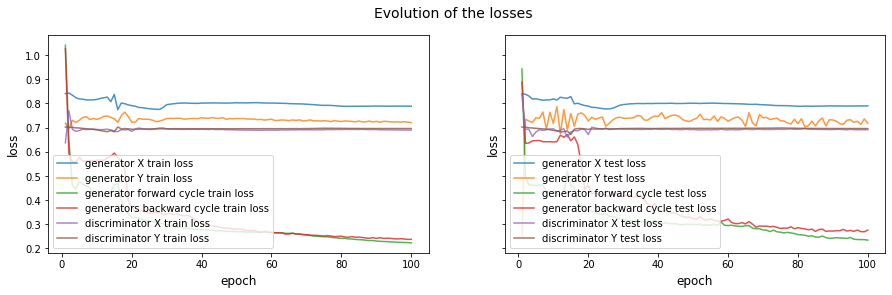

In [17]:
# Visualisation of the evolution of our train losses and test losses

fig, ax = plt.subplots(1, 2, figsize=(15,4), sharex=True, sharey=True)

GX_loss_tr_vs, GY_loss_tr_vs, GCycleX_loss_tr_vs, GCycleY_loss_tr_vs, DX_loss_tr_vs, DY_loss_tr_vs = training_losses

ax[0].plot(np.arange(epochs)+1, GX_loss_tr_vs, label='generator X train loss', alpha=0.8)
ax[0].plot(np.arange(epochs)+1, GY_loss_tr_vs, label='generator Y train loss', alpha=0.8)
ax[0].plot(np.arange(epochs)+1, GCycleX_loss_tr_vs, label='generator forward cycle train loss', alpha=0.8)
ax[0].plot(np.arange(epochs)+1, GCycleY_loss_tr_vs, label='generators backward cycle train loss', alpha=0.8)
ax[0].plot(np.arange(epochs)+1, DX_loss_tr_vs, label='discriminator X train loss', alpha=0.8)
ax[0].plot(np.arange(epochs)+1, DY_loss_tr_vs, label='discriminator Y train loss', alpha=0.8)
ax[0].set_xlabel('epoch', labelpad=5, fontsize='large')
ax[0].set_ylabel('loss', labelpad=5, fontsize='large')
ax[0].legend(loc='best')

GX_loss_te_vs, GY_loss_te_vs, GCycleX_loss_te_vs, GCycleY_loss_te_vs, DX_loss_te_vs, DY_loss_te_vs = testing_losses

ax[1].plot(np.arange(epochs)+1, GX_loss_te_vs, label='generator X test loss', alpha=0.8)
ax[1].plot(np.arange(epochs)+1, GY_loss_te_vs, label='generator Y test loss', alpha=0.8)
ax[1].plot(np.arange(epochs)+1, GCycleX_loss_te_vs, label='generator forward cycle test loss', alpha=0.8)
ax[1].plot(np.arange(epochs)+1, GCycleY_loss_te_vs, label='generator backward cycle test loss', alpha=0.8)
ax[1].plot(np.arange(epochs)+1, DX_loss_te_vs, label='discriminator X test loss', alpha=0.8)
ax[1].plot(np.arange(epochs)+1, DY_loss_te_vs, label='discriminator Y test loss', alpha=0.8)
ax[1].set_xlabel('epoch', labelpad=5, fontsize='large')
ax[1].set_ylabel('loss', labelpad=5, fontsize='large')
ax[1].legend(loc='best')

fig.suptitle('Evolution of the losses', fontsize=14)
plt.show()

Image to skeleton :


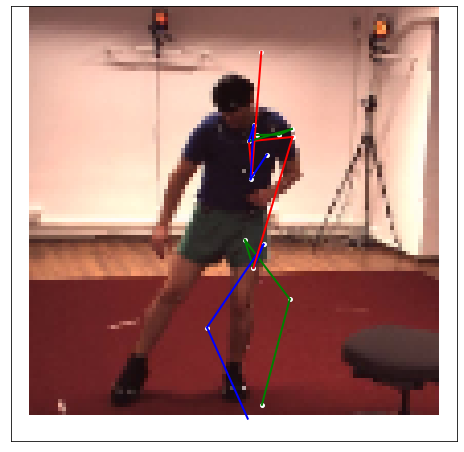

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed image :


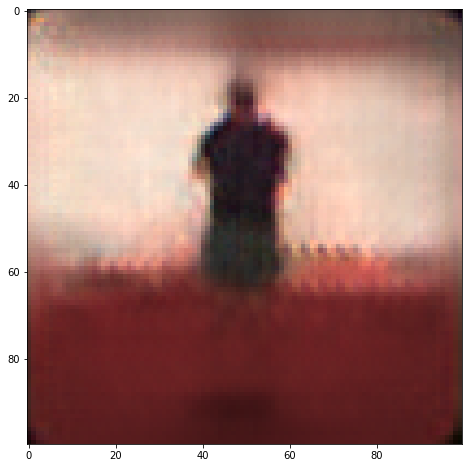

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Skeleton to image :


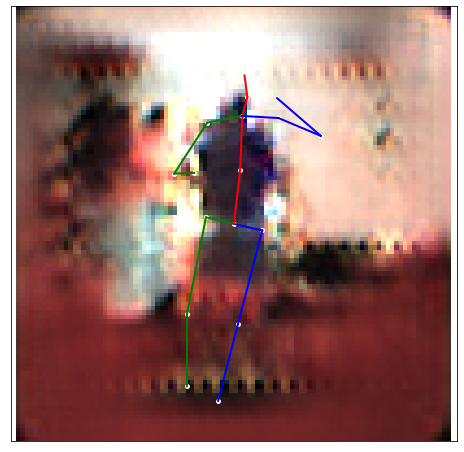

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed skeleton :


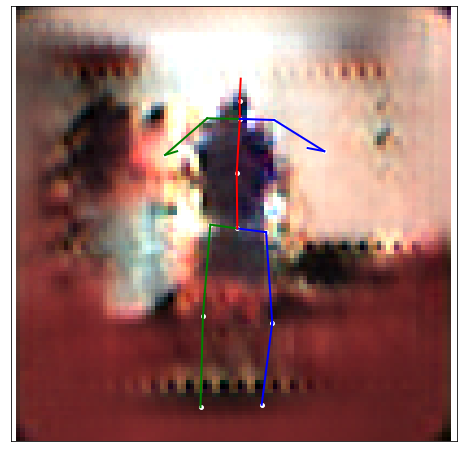

In [21]:
# Get the output from a test sample and visualize it

for it, batch in enumerate(dl_test):
    if (it == 0):
        with torch.no_grad():
            x, y = [d.float().to(device) for d in batch]
            x = x.permute(0,3,1,2) 
            fake_y, rec_x, fake_x, rec_y = cycleGAN(x, y)

            original_image_test = x.permute(0,2,3,1)[0].cpu().numpy().astype(int)
            target_output_test = fake_y[0].cpu().numpy()
            rec_image_test = rec_x.permute(0,2,3,1)[0].cpu().numpy().astype(int)

            original_output_test = y[0].cpu().numpy()
            target_image_test = fake_x.permute(0,2,3,1)[0].cpu().numpy().astype(int)
            rec_output_test = rec_y[0].cpu().numpy()
            
            print("Image to skeleton :")
            visualize(original_image_test, target_output_test)
            print("Reconstructed image :")
            visualize(rec_image_test)
            print("Skeleton to image :")
            visualize(target_image_test, original_output_test)
            print("Reconstructed skeleton :")            
            visualize(target_image_test, rec_output_test)